In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import image
%matplotlib inline
import matplotlib.pylab as plt

from learning2learn.models import simple_cnn

np.random.seed(0)

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data_folder = '../data/images_generated/'
nb_categories = 50
nb_exemplars = 15
shape_fraction = 0.6
color_fraction = 0.2
texture_fraction = 0.2

In [3]:
def load_images(data_folder, target_size=(200, 200)):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    # Now load the feature info
    feature_file = os.path.join(data_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)

    return imgs, df

In [4]:
def build_vocab_training_set(nb_exemplars, nb_categories, shape_fraction, color_fraction):
    # Load the data
    imgs, df = load_images(data_folder, target_size=(200, 200))
    # Select the classes
    nb_shapes = int(nb_categories*shape_fraction)
    nb_colors = int(nb_categories*color_fraction)
    nb_textures = nb_categories - nb_shapes - nb_colors
    assert nb_shapes <= 50 and nb_colors <= 50 and nb_textures <= 50
    shapes = np.random.choice(range(nb_categories), nb_shapes, replace=False)
    colors = np.random.choice(range(nb_categories), nb_colors, replace=False)
    textures = np.random.choice(range(nb_categories), nb_textures, replace=False)
    # ...
    inds = []
    labels = []
    current_class = 0
    for s in shapes:
        ix = np.where(df['shape'].as_matrix() == s)[0]
        inds.extend(list(np.random.choice(ix, nb_exemplars, replace=False)))
        labels.extend([current_class]*nb_exemplars)
        current_class += 1
    for c in colors:
        ix = np.where(df['color'].as_matrix() == c)[0]
        inds.extend(list(np.random.choice(ix, nb_exemplars, replace=False)))
        labels.extend([current_class]*nb_exemplars)
        current_class += 1
    for t in textures:
        ix = np.where(df['texture'].as_matrix() == t)[0]
        inds.extend(list(np.random.choice(ix, nb_exemplars, replace=False)))
        labels.extend([current_class]*nb_exemplars)
        current_class += 1
    
    return imgs[inds], np.asarray(labels)

In [5]:
X, labels = build_vocab_training_set(nb_exemplars, nb_categories, shape_fraction, color_fraction)

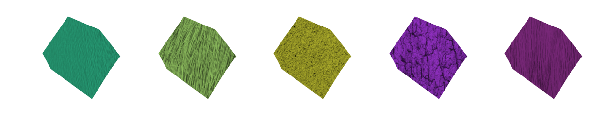

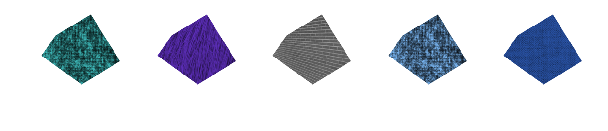

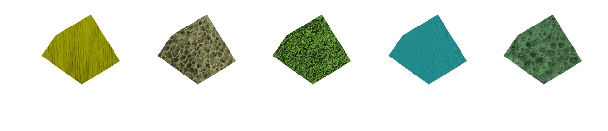

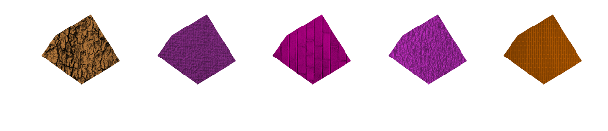

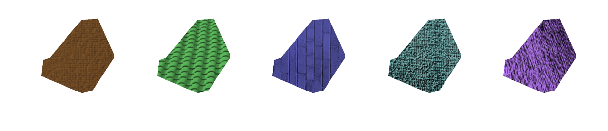

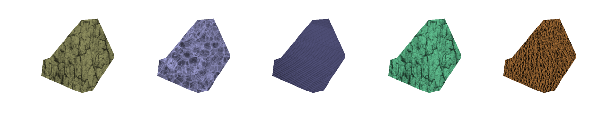

In [6]:
for i in range(6):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,3))
    for j in range(5):
        #ix = i*5+j
        ix = 199 - (i*5+j)
        axes[j].imshow(X[ix])
        axes[j].axis('off')
    plt.show()

In [121]:
ohe = OneHotEncoder(sparse=False)
Y = ohe.fit_transform(labels.reshape(-1, 1))

In [122]:
model = simple_cnn(input_shape=X.shape[1:], nb_classes=Y.shape[-1])

In [124]:
# model.fit(
#     X, Y, epochs=50,
#     shuffle=True, 
#     verbose=1, batch_size=32
# )

## Now try figuring out custom logging...

In [152]:
def make_trial(shapes, colors, textures):
    # create a random trial
    ix = np.arange(len(shapes))
    while True:
        baseline = np.random.choice(ix)
        shape = shapes[baseline]
        color = colors[baseline]
        texture = textures[baseline]
        # only matches in shape
        shape_matches = \
        np.where((shapes == shape) &
                 (colors != color) &
                 (textures != texture))[0]
        # only matches in color
        color_matches = \
        np.where((shapes != shape) &
                 (colors == color) &
                 (textures != texture))[0]
        # only matches in texture
        texture_matches = \
        np.where((shapes != shape) &
                 (colors != color) &
                 (textures == texture))[0]

        if len(shape_matches) > 0 and len(color_matches) > 0 and len(
                texture_matches) > 0:
            break  # make sure we have an option for each image...

    shape_match = np.random.choice(shape_matches)
    color_match = np.random.choice(color_matches)
    texture_match = np.random.choice(texture_matches)

    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(test_folder, nb_trials, target_size=(200, 200)):
    # First, load the images
    imgs = load_image_dataset(test_folder, target_size=target_size)
    # Collect the list of shapes, colors and textures
    feature_file = os.path.join(test_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    shapes = df['shape'].as_matrix()
    colors = df['color'].as_matrix()
    textures = df['texture'].as_matrix()

    # Sample the trials
    ix = []
    for i in range(nb_trials):
        ix.extend(make_trial(shapes, colors, textures))
    ix = np.asarray(ix)
    return imgs[ix]

In [153]:
from learning2learn.util import evaluate_secondOrder

In [142]:
from keras.callbacks import Callback, CSVLogger

class Logger(CSVLogger):
    def on_train_begin(self, logs={}):
        self.secondOrderAcc = []
        super(Logger, self).on_train_begin(logs)
 
    def on_epoch_end(self, epoch, logs={}):
        acc = evaluate_secondOrder(self.model, layer_num=-4)
        self.secondOrderAcc.append(acc)
        super(Logger, self).on_epoch_end(epoch, logs)

In [143]:
logger = Logger('../results/log.csv')
model.fit(
    X[:100], Y[:100], epochs=50,
    shuffle=True, 
    verbose=1, batch_size=32,
    callbacks=[logger]
)

Epoch 1/50
100/100 [==============================] - 59s 594ms/step - loss: 0.0189 - acc: 1.0000
Epoch 2/50
 96/100 [===========================>..] - ETA: 0s - loss: 0.0275 - acc: 1.0000

KeyboardInterrupt: 

## well, shit, that didn't work... let's try a different hack

In [155]:
test_folder = '../data/images_generated/test/'
X_test = build_test_trials(
    test_folder, nb_trials=100,
    target_size=(200, 200)
)

In [156]:
def save_scores(epoch, secondOrderAcc, vocabSize, logfile):
    df = pd.DataFrame(columns=['epoch', 'secondOrderAcc', 'vocabSize'])
    df['epoch'] = epoch
    df['secondOrderAcc'] = secondOrderAcc
    df['vocabSize'] = vocabSize
    df.to_csv(logfile, index=False)

In [208]:
def compute_vocab_size(model, X, Y, batch_size=64):
    # get predictions and ground truth
    y_true = Y.argmax(axis=1)
    y_pred = model.predict_classes(X, batch_size=batch_size)
    # collect accuracies for each class
    classes = np.unique(y_true)
    accuracies = np.zeros_like(classes, dtype=np.float32)
    for i, c in enumerate(classes):
        ix = np.where(y_true == c)[0]
        nb_correct = len(np.where(y_pred[ix] == c)[0])
        accuracies[i] = nb_correct / len(ix)
    # Compute vocab size.
    vocab_size50 = len(np.where(accuracies >= 0.15)[0])
    vocab_size80 = len(np.where(accuracies >= 0.8)[0])

    return vocab_size50, vocab_size80

In [215]:
compute_vocab_size(model, X, Y)

(1, 1)

In [175]:
def show_predictions(model, X, Y):
    y_true = Y.argmax(axis=1)
    y_pred = model.predict_classes(X, batch_size=64)
    classes = np.unique(y_true)
    for c in classes:
        ix = np.where(y_true == c)[0]
        print(y_true[ix])
        print(y_pred[ix])
        print('\n')

In [164]:
y_true = Y.argmax(axis=1)
y_pred = model.predict_classes(X, batch_size=64)

In [210]:
model = simple_cnn(input_shape=X.shape[1:], nb_classes=Y.shape[-1])

In [213]:
epoch = []
secondOrderAcc = []
vocabSize = []
for i in range(2):
    print('Epoch #%i' % (i+1))
    model.fit(
        X[:100], Y[:100], epochs=1,
        shuffle=True, 
        verbose=1, batch_size=32
    )
    acc = evaluate_secondOrder(
        model, X_test, layer_num=-4,
        batch_size=32
    )
    vs = compute_vocab_size(model, X, Y)
    epoch.append(i+1) # 1-indexed
    secondOrderAcc.append(acc)
    vocabSize.append(vs)
    #save_scores(epoch, secondOrderAcc, vocabSize, '../results/log.csv')

Epoch #1
Epoch 1/1
100/100 [==============================] - 3s 30ms/step - loss: 2.0999 - acc: 0.2700
Epoch #2
Epoch 1/1
100/100 [==============================] - 3s 30ms/step - loss: 1.7915 - acc: 0.3000


In [214]:
vocabSize

[(1, 1), (1, 1)]

## Now let's visualize the results of the experiment (which was done on compute node)

In [7]:
def plot_results(df, nb_categories=50, nb_epoch=100):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 20))

    # loss plot
    axes[0,0].plot(df.epoch, df.trainLoss)
    axes[0,0].set_xlabel('Epoch #', fontsize=14)
    axes[0,0].set_ylabel('Training loss', fontsize=14)
    axes[0,0].set_title('Training loss vs. epoch', fontsize=20)
    axes[0,0].set_xlim(0, nb_epoch)
    axes[0,0].set_xticks(list(range(0, nb_epoch,10)))
    # accuracy plot
    axes[0,1].plot(df.epoch, df.trainAcc)
    axes[0,1].set_xlabel('Epoch #', fontsize=14)
    axes[0,1].set_ylabel('Training accuracy', fontsize=14)
    axes[0,1].set_title('Training accuracy vs. epoch', fontsize=20)
    axes[0,1].set_ylim(0,1.1)
    axes[0,1].set_xlim(0, nb_epoch)
    axes[0,1].set_xticks(list(range(0, nb_epoch,10)))
    # vocab size 50% plot
    axes[1,0].plot(df.epoch, df.vocabSize50)
    axes[1,0].set_xlabel('Epoch #', fontsize=14)
    axes[1,0].set_ylabel('Vocab size', fontsize=14)
    axes[1,0].set_title('Vocab size (50%) vs. epoch', fontsize=20)
    axes[1,0].set_ylim(0, nb_categories+1)
    axes[1,0].set_xlim(0, nb_epoch)
    axes[1,0].set_xticks(list(range(0, nb_epoch,10)))
    # vocab size 80% plot
    axes[1,1].plot(df.epoch, df.vocabSize80)
    axes[1,1].set_xlabel('Epoch #', fontsize=14)
    axes[1,1].set_ylabel('Vocab size', fontsize=14)
    axes[1,1].set_title('Vocab size (80%) vs. epoch', fontsize=20)
    axes[1,1].set_ylim(0, nb_categories+1)
    axes[1,1].set_xlim(0, nb_epoch)
    axes[1,1].set_xticks(list(range(0, nb_epoch,10)))
    # shape bias plot
    axes[2,0].plot(df.epoch, df.secondOrderAcc)
    axes[2,0].set_xlabel('Epoch #', fontsize=14)
    axes[2,0].set_ylabel('Second-order gen. accuracy', fontsize=14)
    axes[2,0].set_title('Shape bias vs. epoch', fontsize=20)
    axes[2,0].set_ylim(0, 1.1)
    axes[2,0].set_xlim(0, nb_epoch)
    axes[2,0].set_xticks(list(range(0, nb_epoch,10)))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

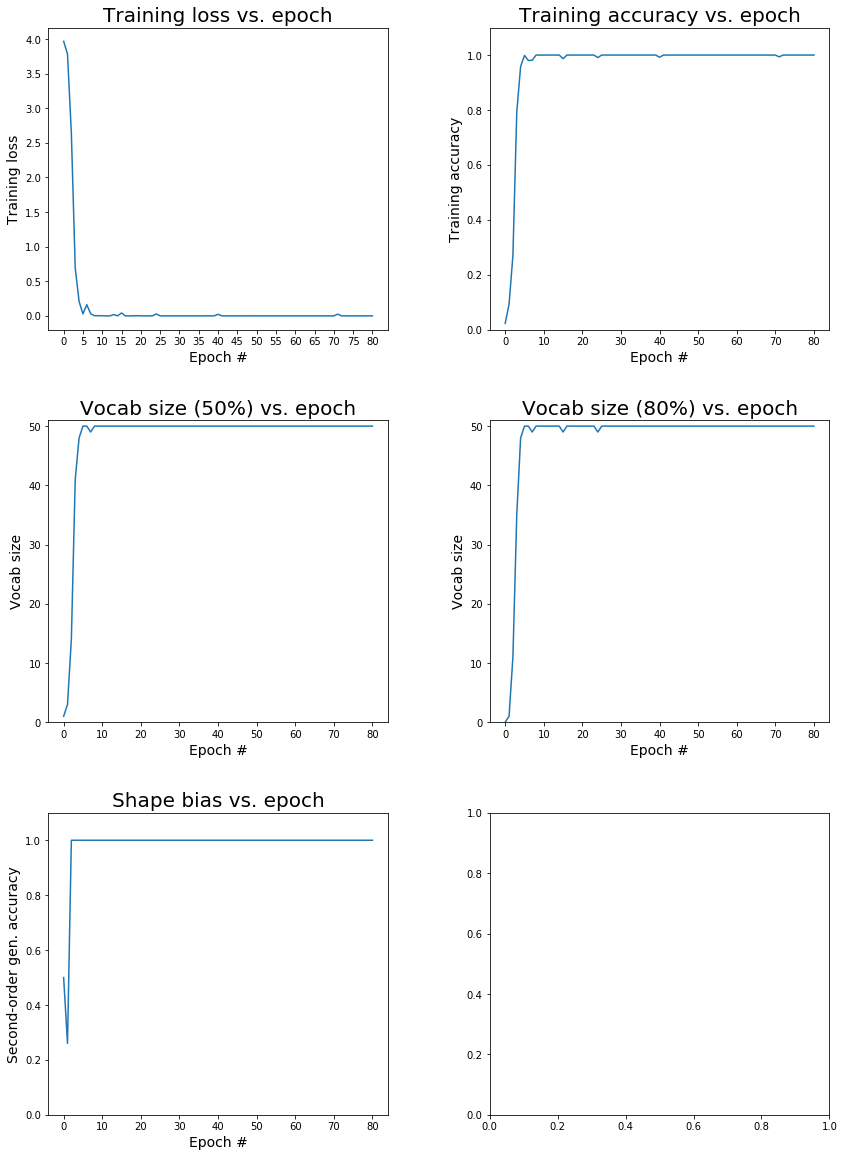

In [8]:
# cutout textures, no shift
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)

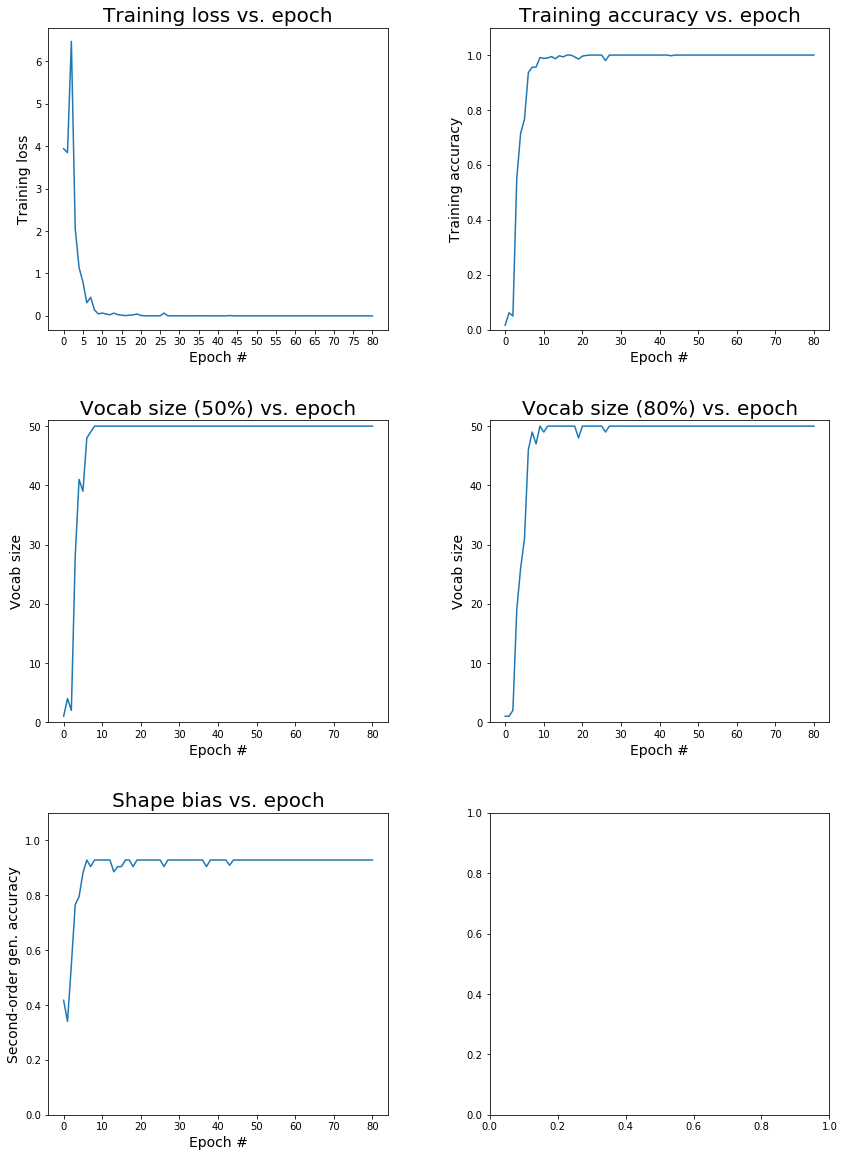

In [17]:
# cutout textures, shift=20
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)

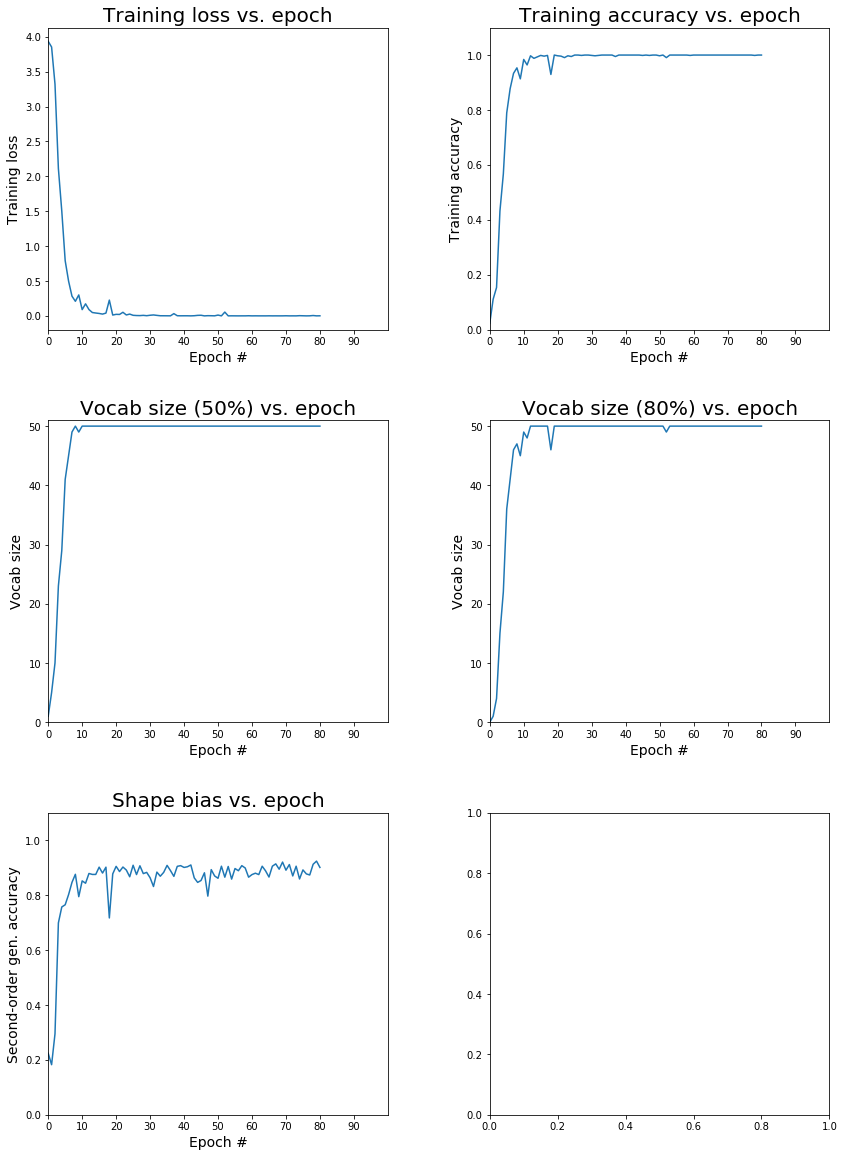

In [9]:
# cutout textures, no shift
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)